# Mini-Project 4

Welcome to your fourth Mini Project! You will build an RNN model to classify text and an LSTM model for anomaly detection (also outlier detection) on the temperature sensor data. **Please complete your assignment in this Jupyter Notebook.**

---

**Requirements**: 
- TensorFlow 2.x is allowed to implement your models.
- Your code should follow [PEP 8](https://www.python.org/dev/peps/pep-0008/) with necessary comments.

## Task 1: Text Classification

This task aims to train a sentiment analysis model to classify given sentences as **positive or negative**, based on the Recurrent Neural Network.

---

**Tasks**

1. Load data
    - Load the training data and the test data.
    - Extract labels and texts which are seperated by the string of `" +++$+++ "`.
    - Eliminate index information in the test data so that you can get pure sentences.
    - Print out the first 10 examples of your training set and test set.
2. Preprocess data
    - Tokenize the data and convert the text to sequences.
    - Add padding to ensure that all the sequences have the same shape.
    - **Hint**: click [here](https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html) for more information.
3. Build RNN model
    - Build a RNN based on TensorFlow 2.x.
    - Visualize the model using [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).
4. Train model
    - Initialize hyperparameters.
    - Train your model.
    - Visualize the performance including training loss, training accuracy, validation loss, and validation accuracy.
5. Predict
    - Test your model on the test data.
    - Save the predicted results (labels and texts) in a CSV file and submit it to Canvas.


In [1]:
import numpy as np

def load_data(train_file_path, test_file_path):
    
    """
        Loads the dataset, from the given file path.
        
        Parameters
        ----------
        train_file_path: string
            Path of the train text file.
        test_file_path: string
            Path of the test text file.
            
        Return
        ----------
        train_data: list
            Output of training sentences.
        test_data: list
            Output of test sentences.
        labels: ndarray
            Output of training labels.
    """
    
    # Empty lists to store training, test and label data
    train_data = [] 
    test_data = [] 
    labels = [] 
    
    # Opening the text file of training and test set
    train_file = open(train_file_path, "r", encoding='utf-8') 
    test_file = open(test_file_path, "r", encoding='utf-8') 
    
    # Reading lines while ignoring header for test data
    train_lines = train_file.readlines() 
    test_lines = test_file.readlines()[1:]
    
    # Loop to iterate and store the training sentences and labels
    for line in train_lines: 
        train_data.append(line.split(' +++$+++ ')[1])
        labels.append(line[:1])
    
    # Loop to iterate and store the test sentences
    for line in test_lines: 
        test_data.append(line.split(',',maxsplit=1)[1])
    
    # Converting list of strings labels to numpy array of integer labels
    y_train = np.array([int(i) for i in labels])
    y_train = np.reshape(y_train, (len(y_train), 1))
    
    return train_data, y_train, test_data

In [2]:
train_data, y_train, test_data = load_data('task1_training_data.txt', 'task1_test_data.txt')

# Printing 10 examples from the training set
print("################ First 10 Examples From The Training Set ################\n")
for i in range(0,10):
    print("{}: {}".format(i+1, train_data[i]))
    
# Printing 10 examples from the test set
print("################ First 10 Examples From The Test Set ################\n")
for i in range(0,10):
    print("{}: {}".format(i+1, test_data[i]))

################ First 10 Examples From The Training Set ################

1: are wtf ... awww thanks !

2: leavingg to wait for kaysie to arrive myspacin itt for now ilmmthek .!

3: i wish i could go and see duffy when she comes to mamaia romania .

4: i know eep ! i can ' t wait for one more day ....

5: so scared and feeling sick . fuck ! hope someone at hr help ... wish it would be wendita or karen .

6: my b day was thurs . i wanted 2 do 5 this weekend for my b day but i guess close enough next weekend . going alone

7: e3 is in the trending topics only just noticed ive been tweeting on my iphone until now

8: where did you get him from i know someone who would love that !

9: dam just got buzzed by another huge fly ! this time it landed on my head ... not impressed

10: tomorrowwwwwwwww !!! you ' ll love tomorrow ' s news !

################ First 10 Examples From The Test Set ################

1: my dog ate our dinner . no , seriously ... he ate it .

2: omg last day sooon n of 

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(X_train, X_test):
    
    """
        Tokenizes the data and converts it to padded training sequences.
        
        Parameters
        ----------
        X_train: list
            Input of training dataset 
        X_test: list
            Input of test dataset
            
        Return
        ----------
        X_train: ndarray
            Output of tokenized training data converted to padded training sequences.
        X_test: ndarray
            Output of tokenized test data converted to padded training sequences.
    """
    
    # Defining hyperparameters for performing tokenization 
    features = 20000
    oov_token = '<UNK>'
    pad_type = 'post'
    trunc_type = 'post'
    
    # Tokenizing the training data
    tokenizer_train = Tokenizer(num_words=features, oov_token=oov_token)
    tokenizer_train.fit_on_texts(X_train)
    
    # Tokenize the test data
    tokenizer_test = Tokenizer(num_words=features, oov_token=oov_token)
    tokenizer_test.fit_on_texts(X_test)
    
    # Getting training and test data word index    
    word_index_train = tokenizer_train.word_index
    word_index_test = tokenizer_test.word_index

    # Encoding training and test data sentences into sequences
    train_sequences = tokenizer_train.texts_to_sequences(X_train)
    test_sequences = tokenizer_test.texts_to_sequences(X_test)

    # Taking out max length for truncation
    maxlen = max([len(x) for x in train_sequences])

    # Pad the training sequences
    X_train = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
    X_test = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
    
    return X_train, X_test

In [4]:
X_train, X_test = preprocess_data(train_data, test_data)

In [5]:
from tensorflow.keras import datasets, layers, models

def my_rnn_model(data):
        
    """
        Recurrent neural network model using sequential API.
        
        Parameters
        ----------
        data: ndarray
            Input of training dataset 
           
        Return: An instance of RNN model    
    """
    
    model = tf.keras.Sequential([
      layers.Embedding(20000,5),
      layers.Dropout(0.4),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.4),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')])

    return model

In [6]:
model = my_rnn_model(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 5)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 100,225
Trainable params: 100,225
Non-trainable params: 0
__________________________________________________

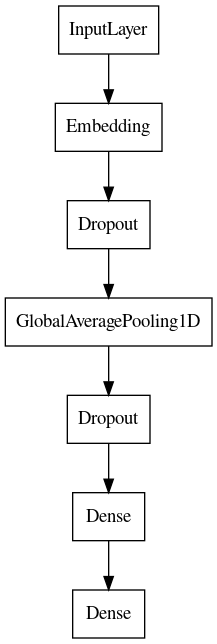

In [7]:
# Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Visualizing model summary
model.summary()

# Visualizing model structure 
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96,
)

In [8]:
from sklearn.model_selection import train_test_split

# Model training and validation
history = model.fit(X_train, y_train, epochs=10, validation_split=0.25, verbose=1)                                             

Epoch 1/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.6060 - accuracy: 0.6623 - val_loss: 0.4836 - val_accuracy: 0.7827
Epoch 2/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.5027 - accuracy: 0.7646 - val_loss: 0.4730 - val_accuracy: 0.7864
Epoch 3/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.4861 - accuracy: 0.7736 - val_loss: 0.4706 - val_accuracy: 0.7881
Epoch 4/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.4821 - accuracy: 0.7777 - val_loss: 0.4696 - val_accuracy: 0.7884
Epoch 5/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.4759 - accuracy: 0.7824 - val_loss: 0.4692 - val_accuracy: 0.7863
Epoch 6/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.4704 - accuracy: 0.7858 - val_loss: 0.4697 - val_accuracy: 0.7864
Epoch 7/10
4688/4688 [==============================] - 8s 2ms/step - loss: 0.4676 - accuracy: 0.7854 - val_loss: 0.4724 - val_accuracy:

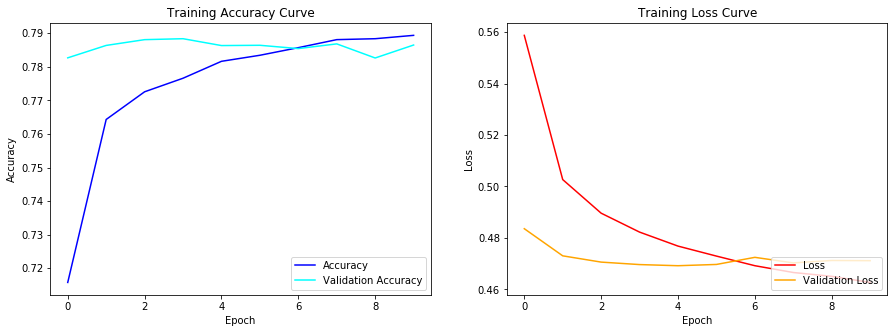

In [15]:
import matplotlib.pyplot as plt

# Visualizing the training accuracy curve
plt.figure(figsize=(15,5))
plt.subplot(1,2,1, title='Training Accuracy Curve')
plt.plot(history.history['accuracy'], label='Accuracy', color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
legend = plt.legend(loc='lower right')

# Visualizing the training loss curve
plt.subplot(1,2,2, title='Training Loss Curve')
plt.plot(history.history['loss'], label='Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
legend = plt.legend(loc='lower right')

In [17]:
# Prediciting labels for test data -> 'POSITIVE' if prediciton is greater than 0.5, otherwise 'NEGATIVE'
prediction = model.predict(X_test)
prediction = np.array(['Positive' if i>0.5 else 'Negative' for i in prediction])

In [18]:
import pandas as pd

# Saving the predicted labels and texts in csv
df = pd.DataFrame({'Test Sentences':test_data, 'Prediction': prediction})
df.to_csv("task1.csv")

## Task 2: Anomaly Detection

In manufacturing industries, the anomaly detection technique is applied to predict the abnormal activities of machines based on the data read from sensors. In machine learning and data mining, anomaly detection is the task of identifying the rare items, events, or observations that are suspicious and seem different from the majority of the data. In this task, you will predict the possible failure of the system based on the temperature data. And this failure can be detected by check if they follow the trend of the majority of the data.

---

**Dataset**

The given dataset (`ambient_temperature_system_failure.csv`) is a part of Numenta Anomaly Benchmark (NAB) dataset, which is a novel benchmark for evaluating machine learning algorithms in anomaly detection.

**Tasks**

Because the labels have not been given, you will need to use a LSTM based model to capture the trend of the feature for majority of the data. First, extract $n_x$ features from each of the raw data point. Second, create a sliding window with length $l$. Third, fomulate LSTM taking a matrix of shape $l \times n_x$ as the input to predict the temperature value of the next time step $l+1$. Last, compare the predicted result and the real data and find out abnormal points where the difference between these two values are larger than the threshold. 

For instance, if we want to extract 3 features ($n_x=3$), and set the sliding window length to 100 ($l=100$). Then LSTM will take the first 100 (e.g., $[0:100]$) time step data as the input to predict the temperature value of the next time step (e.g., 100). The shape of the input will be $100 \times 3$, and shape of the output will be a single number.

1. Load data
    - Read the CSV file.
    - Draw a curve to visualize the time-series data.
2. Preprocess data
    - The raw data of temperature is the degree Fahrenheit, you will need to convert it into degree Celcius.
    - Use Pandas package convert string timestamp data into the datatime data. Click [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) for details.
3. Feature Engineering
    - We will use datatime data to generate four features: hours, day or night, day of the week, weekday or weekends.
    - Hour: convert datetime data into hours. The result of your processed data will be [0, 1, 2, ..., 22, 23, 0, 1, ..., 22, 23]. Check [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.hour.html).
    - Day or night: this will be a binary data. 7:00-22:00 will be day time, the rest will be night.
    - Day of the week: convert datetime data into day of the week. The result of your processed data will be [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6 ...]. Click [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html) for more information.
    - Workday or weekend: this will be a binary data. Monday to Friday will be workdays, Saturday and Sunday are weekend.
    
4. Prepare training and testing data
    - Split the dataset into training set and test set.
    - Min-max normalization.
    - Generate sliding window (similar to the last task of HW1) data.
3. Build LSTM model
    - Build an LSTM model using TensorFlow 2.x.
    - Visualize your model.
4. Train model
    - Initialize hyperparameters.
    - Train the model.
    - Evaluate the trained model on the test data.
    - Visualize the performance including training loss and test loss.
5. Find anomalies
    - Specify the threshold and predict anomalies on testing dataset.
    - Visualize the anomalies.


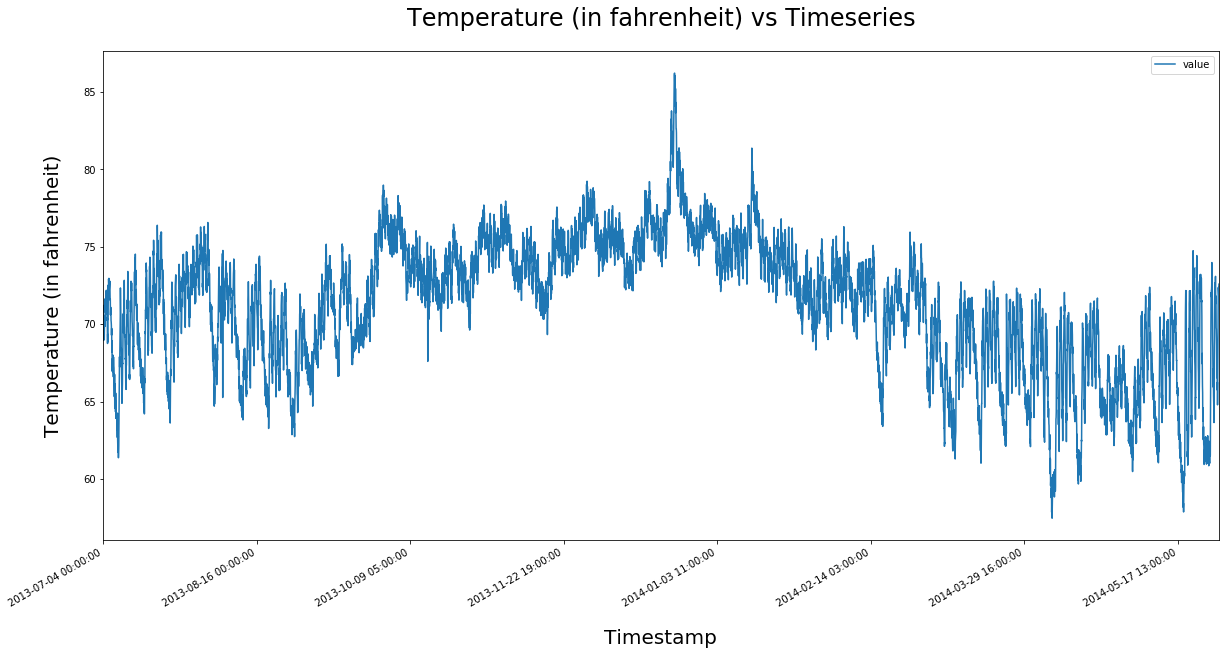

In [377]:
import pandas as pd
import numpy as np

"""------------ LOADING DATA ------------"""

# Reading the csv file
df = pd.read_csv('ambient_temperature_system_failure.csv')

# Visualizing time-series data
df.plot('timestamp','value', figsize=(20,10))
plt.title('Temperature (in fahrenheit) vs Timeseries', fontsize=24, pad=25)
plt.ylabel('Temperature (in fahrenheit)', fontsize=20, labelpad=20)
plt.xlabel('Timestamp', fontsize=20, labelpad=20)
plt.gcf().autofmt_xdate()

In [378]:
"""------------ DATA PREPROCESSING ------------"""

# Converting fahrenheit values to celsius 
df = df.assign(value = lambda x: (x['value']-32)*(5/9))

# Converting string timestamp data to datatime data
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%f')

In [379]:
"""------------ FEATURE ENGINEERING ------------"""

# Converting datetime data into hours and storing it in a new column 'hour'
df['hour'] = df['timestamp'].dt.hour

# Classifying datetime data into 'day or night' and storing it in a new column 'session'
bins=[0,6,22,23]
labels=[0, 1, 0]
df['session'] = pd.cut(df["hour"], bins, labels=False, include_lowest=True).map({i: x for i, x in enumerate(labels)})

# Classifying datetime data into day of the week and storing it in a new column 'day'
df['day']  = df['timestamp'].dt.dayofweek

# Classifying datetime data into 'workday and weekend' and storing it in a new column 'waw'
dayOfWeek={0:1, 1:1, 2:1, 3:1, 4:1, 5:0, 6:0}
df['waw'] = df['timestamp'].dt.dayofweek.map(dayOfWeek)

In [393]:
"""------------ PREPARE TRAINING AND TESTING DATA ------------"""

# Splitting the data into training and testing dataset
train_size = int(0.7 * len(df))
X_train = df[:train_size]
X_test = df[train_size:]

# Appying min-max normalization on all columns except the index and timestamp columns
for column in df_max_scaled.columns[1:]:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
      
# Generating sliding window


,timestamp,value,hour,session,day,waw
0,2013-07-04 00:00:00,0.698609,0.000000,0.0,0.500000,1.0
1,2013-07-04 01:00:00,0.723311,0.043478,0.0,0.500000,1.0
2,2013-07-04 02:00:00,0.716996,0.086957,0.0,0.500000,1.0
3,2013-07-04 03:00:00,0.681616,0.130435,0.0,0.500000,1.0
4,2013-07-04 04:00:00,0.687594,0.173913,0.0,0.500000,1.0
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.744519,0.478261,1.0,0.333333,1.0
7263,2014-05-28 12:00:00,0.740881,0.521739,1.0,0.333333,1.0
7264,2014-05-28 13:00:00,0.738550,0.565217,1.0,0.333333,1.0
7265,2014-05-28 14:00:00,0.734468,0.608696,1.0,0.333333,1.0


In [384]:
# Prepare training and testing data
# Split the dataset into training set and test set.
# Min-max normalization.
# Generate sliding window (similar to the last task of HW1) data.

In [392]:
df_max_scaled = df.copy()
  


,timestamp,value,hour,session,day,waw
0,2013-07-04 00:00:00,0.698609,0.000000,0.0,0.500000,1.0
1,2013-07-04 01:00:00,0.723311,0.043478,0.0,0.500000,1.0
2,2013-07-04 02:00:00,0.716996,0.086957,0.0,0.500000,1.0
3,2013-07-04 03:00:00,0.681616,0.130435,0.0,0.500000,1.0
4,2013-07-04 04:00:00,0.687594,0.173913,0.0,0.500000,1.0
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.744519,0.478261,1.0,0.333333,1.0
7263,2014-05-28 12:00:00,0.740881,0.521739,1.0,0.333333,1.0
7264,2014-05-28 13:00:00,0.738550,0.565217,1.0,0.333333,1.0
7265,2014-05-28 14:00:00,0.734468,0.608696,1.0,0.333333,1.0
